In [3]:
import folium
import pandas as pd
import numpy as np
import os

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [126]:
def read_csv(filename):
    df = pd.read_csv(filename)
    NewLap_idx = df[df.Time == 'New Lap'].index
    df.drop('heartratebpm/value',axis=1, inplace=True)
    df.dropna(how='any',axis=0, inplace=True)
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
    df['Time'] = df['Time'].apply(lambda x: dateparse(x))
    df['dist'] = \
        haversine_np(df.LongitudeDegrees.shift(), df.LatitudeDegrees.shift(),
                     df.loc[1:, 'LongitudeDegrees'], df.loc[1:, 'LatitudeDegrees'])
    df['cum_dis'] = df.dist.cumsum()
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.seconds
    df['Speed'] = df.apply(lambda x: x['dist']/x['DeltaTime']*3600 if x['DeltaTime'] else np.NaN, axis=1)
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.seconds
    df['DeltaAltitude'] = df.AltitudeMeters - df.AltitudeMeters.shift()
    return df, NewLap_idx

In [127]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [128]:
path = 'data/csv/'
allFiles = os.listdir(path)
frame = pd.DataFrame()
list_df = []
list_newlap = []
for file_ in allFiles:
    df, newlap = read_csv(path + file_)
    list_df.append(df)
    list_newlap.append(newlap)

In [141]:
list_df[15].head()

,Time,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,dist,cum_dis,DeltaTime,Speed,DeltaAltitude
0,2016-10-08 05:20:17,36.460728,25.390005,194.0,NaN,NaN,NaN,NaN,NaN
1,2016-10-08 05:20:18,36.460728,25.390005,195.0,0.000000,0.000000,1.0,0.000000,1.0
2,2016-10-08 05:20:19,36.460728,25.390005,195.0,0.000000,0.000000,1.0,0.000000,0.0
3,2016-10-08 05:20:20,36.460730,25.390005,195.0,0.000222,0.000222,1.0,0.800101,0.0
4,2016-10-08 05:20:20,36.460730,25.390005,195.0,0.000000,0.000222,0.0,NaN,0.0


In [9]:
number = 15
m = folium.Map(location=[np.mean([i[0] for i in [[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in list_df[number].iterrows()]]), np.mean([i[1] for i in [[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in list_df[number].iterrows()]])], zoom_start=16, tiles='OpenStreetMap')
folium.PolyLine([[float(v.LatitudeDegrees), float(v.LongitudeDegrees)] for k,v in list_df[number].iterrows()], color='blue',opacity=1 ).add_to(m)
for i in list_newlap[number]:
    folium.Marker([list_df[number].iloc[i-len(list_newlap[number])]['LatitudeDegrees'],list_df[number].iloc[i-len(list_newlap[number])]['LongitudeDegrees'] ], popup=str(i)).add_to(m)
m

In [164]:
m.save('us_states.html',)

In [11]:
number=15
trace_high = go.Scatter(
                x=list_df[number].Time,
                y=list_df[number].AltitudeMeters,
                name = "Altitude",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_low = go.Scatter(
                x=list_df[number].Time,
                y=list_df[number].Speed.rolling(window=10).mean(),
                name = "Speed",
                line = dict(color = '#7F7F7F'),
                yaxis='y2',
                opacity = 0.8)

data = [trace_high, trace_low]

layout = dict(
    #title = "Manually Set Date Range",
    yaxis=dict(
        title='Altitude',
        titlefont=dict(
            color='#17BECF'
        ),
        tickfont=dict(
            color='#17BECF'
        )
    ),
    yaxis2=dict(
        title='Speed',
        titlefont=dict(
            color='#7F7F7F'
        ),
        tickfont=dict(
            color='#7F7F7F'
        ),
        anchor='free',
        overlaying='y',
        side='right',
        position=1.0
    ),
    #xaxis = dict(
    #    range = ['2016-07-01','2016-12-31'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Manually Set Range")

In [12]:
import pygal
from IPython.core.display import display, HTML, SVG

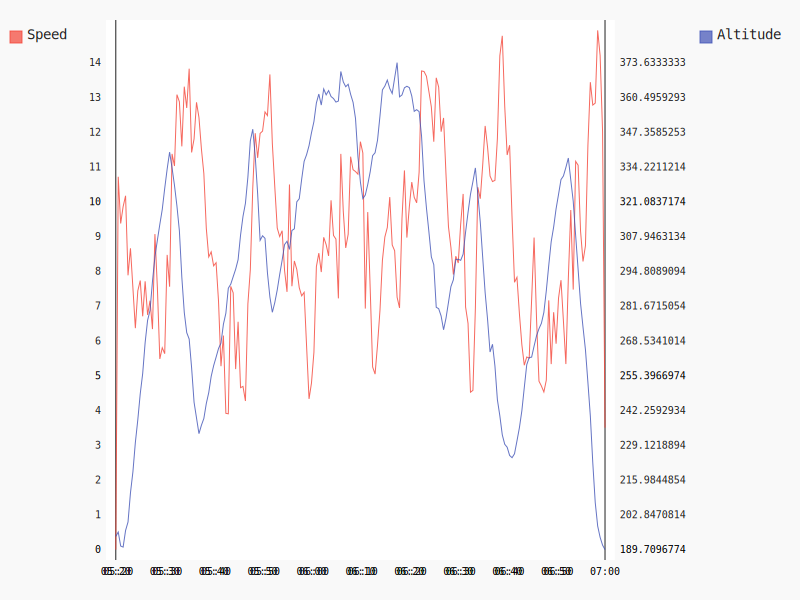

In [181]:
line_chart = pygal.Line(x_labels_major_every=20, show_minor_x_labels=False, truncate_label=5, show_y_guides=False, show_dots=False)
#line_chart.x_labes=map(str, (pd.concat([list_df[number]['Speed'].rolling(window=10).mean(), list_df[number]['Time']], axis=1).resample('30s', on='Time').mean().reset_index()['Time'].dt.year.values))
line_chart.x_labels = map(lambda d: d.strftime('%H:%M'), pd.concat([list_df[number]['Speed'].rolling(window=10).mean(), list_df[number]['Time']], axis=1).resample('30s', on='Time').mean().reset_index()['Time'])
line_chart.add('Speed', pd.concat([list_df[number]['Speed'].rolling(window=10).mean(), list_df[number]['Time']], axis=1).resample('30s', on='Time').mean().reset_index()['Speed'].fillna(0))
line_chart.add('Altitude', pd.concat([list_df[number]['AltitudeMeters'], list_df[number]['Time']], axis=1).resample('30s', on='Time').mean().reset_index()['AltitudeMeters'].fillna(0),secondary=True)
display(SVG(line_chart.render(is_unicode=True)))
line_chart.render_to_file('./save.svg')

# Export to csv

In [103]:
df_resampled = pd.concat([list_df[number][['Speed', 'AltitudeMeters']].rolling(window=10).mean(), list_df[number]['Time']], axis=1).resample('30s', on='Time').mean().reset_index()
np.savetxt("speed.csv", df_resampled['Speed'].fillna(0).values, delimiter=",",fmt='%.2f', newline=',')
np.savetxt("altitude.csv", df_resampled['AltitudeMeters'].values, delimiter=",",fmt='%.2f', newline=',')
np.savetxt("time.csv", df_resampled['Time'].apply(lambda d: "%.2d:%.2d:%.2d" % ((d - df_resampled['Time'][0]).seconds//3600,((d - df_resampled['Time'][0]).seconds//60)%60, (d - df_resampled['Time'][0]).seconds%60)).values, delimiter=",",fmt='\'%s\'', newline=',')

# Table Interval

In [182]:
number = 15
df_interval = list_df[number].groupby(list_df[number]['cum_dis'].apply(lambda x: np.ceil(x))).agg({'DeltaTime' : sum, 'Speed': np.mean, 'DeltaAltitude' : np.sum}).reset_index()
np.savetxt("interval_speed.csv", df_interval['Speed'].fillna(0).values, delimiter=",",fmt='%.2f', newline=',')
np.savetxt("interval_altitud.csv", df_interval['DeltaAltitude'].fillna(0).values, delimiter=",",fmt='%.1f', newline=',')
np.savetxt("interval_dis.csv", df_interval['cum_dis'].fillna(0).values, delimiter=",",fmt='%.1f', newline=',')

In [156]:
df_interval

,cum_dis,DeltaTime,Speed,DeltaAltitude
0,0.0,2.0,0.000000,1.0
1,1.0,451.0,7.988852,98.0
2,2.0,385.0,9.330590,-15.0
3,3.0,313.0,11.524092,-26.0
4,4.0,546.0,6.600975,90.0
5,5.0,314.0,11.455841,-49.0
6,6.0,485.0,7.432455,66.0
7,7.0,391.0,9.187743,1.0
8,8.0,419.0,8.592033,5.0
9,9.0,390.0,9.245032,-6.0


## Altitude distance from min to max 

In [170]:
list_df[number]['AltitudeMeters'].max() - list_df[number]['AltitudeMeters'].min()

189.0

## Cumulated climb altitude

In [178]:
list_df[number]['DeltaAltitude'][list_df[number]['DeltaAltitude'] > 0].sum()

1486.0

In [157]:
data=[go.Bar(x=df_interval['cum_dis'], y=df_interval['Speed'])]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')